# Decision Tree Exercise

In this exercise you'll build your own decision tree to predict wine quality based on its ingredients.

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, r2_score

np.set_printoptions(precision=2) # numpy prints all numbers up to 2nd decimals 

The data data is taken from [*P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. In Decision Support Systems, Elsevier*](https://archive.ics.uci.edu/dataset/186/wine+quality). The inputs include objective tests (e.g. PH values) and the output is based on sensory data(median of at least 3 evaluations made by wine experts). Each expert graded the wine quality between 0 (very bad) and 10 (very excellent) of red and white variants of the Portuguese "Vinho Verde" wine.


Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol
12. color

Output variable (based on sensory data): 

13. quality (score between 0 and 10)

I'll import the data for you. Note, that the dataset mostly contains wines of mediocre quality.

In [152]:
wines: pd.DataFrame = pd.read_csv('winequality.csv')
print(wines["quality"].value_counts().sort_index())
wines.head()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


You might notice that the `color` column is an odd one out. It's a categorical column in a otherwise numerical dataset. The Decision Tree will have difficulty to deal with this, so start by converting the categorical data as string to a numerical datatype.

Another less obvious problem is, that the data type of quality is an integer. It's not a direct problem, but the plotting function expects string classes. Transform it to strings as well now.

Transform the `color` column to a categorical datatype and create the new column `color numerical` by using its category codes. Alternatively, map the values of `color` to `1` for `"white"` and `0` for `"red"` to create the new `color numerical` column. Also transform the `quality` column to the `str` datatype.

In [153]:
wines["color"] = wines["color"].astype('category')
wines["color numerical"] = wines["color"].cat.codes
wines["quality"] = wines["quality"].astype(str).astype('category')
wines.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,color numerical
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6,white,1


In [154]:
# Test cell

assert "color numerical" in wines.columns, "The column 'color numerical' is missing. Create it by converting the 'color' column to a numerical value."
assert wines["color numerical"].nunique() == 2, "The 'color numerical' column should have 2 unique values."
assert np.array(wines["color numerical"].unique() == [1, 0]).all(), "The 'color numerical' column should have the values 0 and 1."

Next, create a sub-`pd.DataFrame` of the features and a `pd.Series` with the target for the wine quality prediction. Also, split the features and the target into a train and a test set. The test set should contain 20% of the data.

Create a `pd.DataFrame` called `features` and a `pd.Series` called `target`. Split these two variables into the variables `X_train`, `X_test`, `y_train`, `y_test` with the test variables containing 20% of the data. 

In [155]:
features_list: list = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "color numerical"]
features: pd.DataFrame = wines[features_list]
target: pd.Series = wines["quality"]

X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [156]:
# Test cell

test_size: float = 0.2
train_size: float = 1 - test_size

assert features is not None, "The 'features' DataFrame is missing."
assert target is not None, "The 'target' Series is missing."
assert X_train is not None, "The 'X_train' array is missing."
assert X_test is not None, "The 'X_test' array is missing."
assert y_train is not None, "The 'y_train' array is missing."
assert y_test is not None, "The 'y_test' array is missing."

assert features.shape[1] == 12, f"The 'features' DataFrame has the wrong number of columns. Expected: 12, Actual: {features.shape[1]}"

assert X_train.shape[0] == int(wines.shape[0] * train_size), f"The training set has the wrong number of samples. Expected: {int(wines.shape[0] * train_size)}, Actual: {X_train.shape[0]}"
assert X_test.shape[0] == int(wines.shape[0] * test_size)+1, f"The test set has the wrong number of samples. Expected: {int(wines.shape[0] * test_size)+1}, Actual: {X_test.shape[0]}"
assert y_train.shape[0] == int(wines.shape[0] * train_size), f"The training set has the wrong number of labels. Expected: {int(wines.shape[0] * train_size)}, Actual: {y_train.shape[0]}"
assert y_test.shape[0] == int(wines.shape[0] * test_size)+1, f"The test set has the wrong number of labels. Expected: {int(wines.shape[0] * test_size)+1}, Actual: {y_test.shape[0]}"


Create your decision Tree. We now have a much higher dimensional problem and even worse: more possible classes. Our tree will be therefore much larger until a proper classification is possible. Let's use a depth of 12 levels.

Create a variable for your tree called `tree_model`. Use a depth of 12, the gini-criterion and show it a random subset of 80% of the features at each level.

In [157]:
tree_model: tree.DecisionTreeClassifier = tree.DecisionTreeClassifier(max_depth=12, criterion="gini", max_features=0.8)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features=0.8)

In [158]:
# Test cell

assert tree_model is not None, "The model is missing. You should create a decision tree model."
assert tree_model.max_depth == 12, "The model should have a max depth of 12."
assert tree_model.criterion == "gini", "The model should use the 'gini' criterion."
assert tree_model.max_features == 0.8, "The model should use 80% of the features."
assert hasattr(tree_model, "tree_"), "The model has not been trained. You should fit the model to the training data."

You can try to plot the tree, but with 12 levels you need a quite large figure. Feel free to comment out the code and get an impression of the tree. Ideally, the final leaf nodes should be pure.

In [159]:
# plt.figure(figsize=(400, 30))
# tree.plot_tree(tree_model, feature_names=features_list, class_names=tree_model.classes_, filled=True, precision=1, fontsize=5)
# plt.show()

Now that we have trained the model, we can use it to make predictions on the test set. We can then evaluate the model's performance by comparing the predicted labels to the actual labels in the test set.

Then, calculate the accuracy and recall of the model using the test set labels and the predicted labels.
Plot the confusion matrix using the test set labels and the predicted labels.
Finally, convert the true and and predicted labels to numerical values again and also calculate the mean absolute error to assess how wrong the model is on average. Also the R2-score will give you a comparison to simply guessing the mean of the distribution.

Create a variable called `y_predict` and assign it the predicted labels for the test set. Assign the `accuarcy`, `recall`, and `MAE` to variables of the same name.


Accuracy: 0.59
Recall: 0.59
Mean Absolute Error: 0.48
R2 Score: 0.11


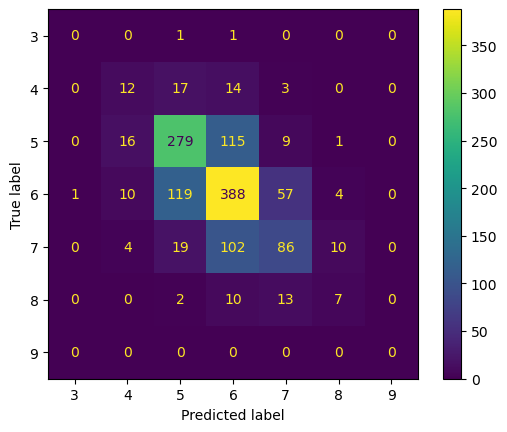

In [160]:
y_predict: np.ndarray = tree_model.predict(X_test)

accuracy: float = accuracy_score(y_test, y_predict)
recall: float = recall_score(y_test, y_predict, average="weighted", zero_division=0)
MAE: float = mean_absolute_error(np.array(y_test), np.array(y_predict))
R2: float = r2_score(np.array(y_test), np.array(y_predict))
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")

print(f"Mean Absolute Error: {MAE:.2f}")
print(f"R2 Score: {R2:.2f}")

cm: np.ndarray = confusion_matrix(y_test, y_predict, labels=tree_model.classes_)
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_model.classes_)
disp.plot()
plt.show()

Instead of using a single decision tree, you can use a random forest to improve the model's performance. A random forest is an ensemble learning method that creates multiple decision trees and combines their predictions. This approach can help reduce overfitting and improve the model's accuracy.

Create a random forest classifier named `forest_model` with the following parameters: - n_estimators: 100 - max_depth: 12 - criterion: "gini" - max_features: 0.8.
Fit the model to the training data.

In [161]:
forest_model: RandomForestClassifier = RandomForestClassifier(n_estimators=500, max_depth=12, criterion="gini", max_features=0.8)
forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features=0.8, n_estimators=500)

In [162]:
# Test cell

assert forest_model is not None, "The model is missing. You should create a random forest model."
assert forest_model.n_estimators == 500, "The model should have 500 estimators."
assert forest_model.max_depth == 12, "The model should have a max depth of 12."
assert forest_model.criterion == "gini", "The model should use the 'gini' criterion."
assert forest_model.max_features == 0.8, "The model should use 80% of the features."
assert hasattr(forest_model, "estimators_"), "The model has not been trained. You should fit the model to the training data."

Again, we can evaluate the model using the test data and the metrics we have used before.

Create a variable called `y_predict` and assign it the predicted labels for the test set. Assign the `accuarcy`, `recall`, `MAE`, and `R2` to the variables `accuracy`, `recall`, `MAE`, and `R2` respectively and print them. Finally, print the confusion matrix.

Accuracy: 0.67
Recall: 0.67
Mean Absolute Error: 0.35
R2 Score: 0.42


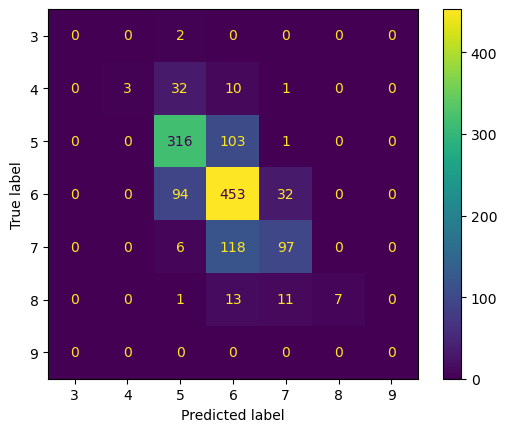

In [163]:
y_predict: np.ndarray = forest_model.predict(X_test)

accuracy: float = accuracy_score(y_test, y_predict)
recall: float = recall_score(y_test, y_predict, average="weighted", zero_division=0)
MAE: float = mean_absolute_error(np.array(y_test), np.array(y_predict))
R2: float = r2_score(np.array(y_test), np.array(y_predict))
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Mean Absolute Error: {MAE:.2f}")
print(f"R2 Score: {R2:.2f}")

cm: np.ndarray = confusion_matrix(y_test, y_predict, labels=forest_model.classes_)
disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_model.classes_)
disp.plot()
plt.show()

Did the forest perform better than the tree? Can you still improve the results?